# Optimisation des modèles

Faire tourner des modèles c'est bien, en optimiser les performances c'est encore mieux. En tant que Data Scientist en herbe, vous voulez les deux !

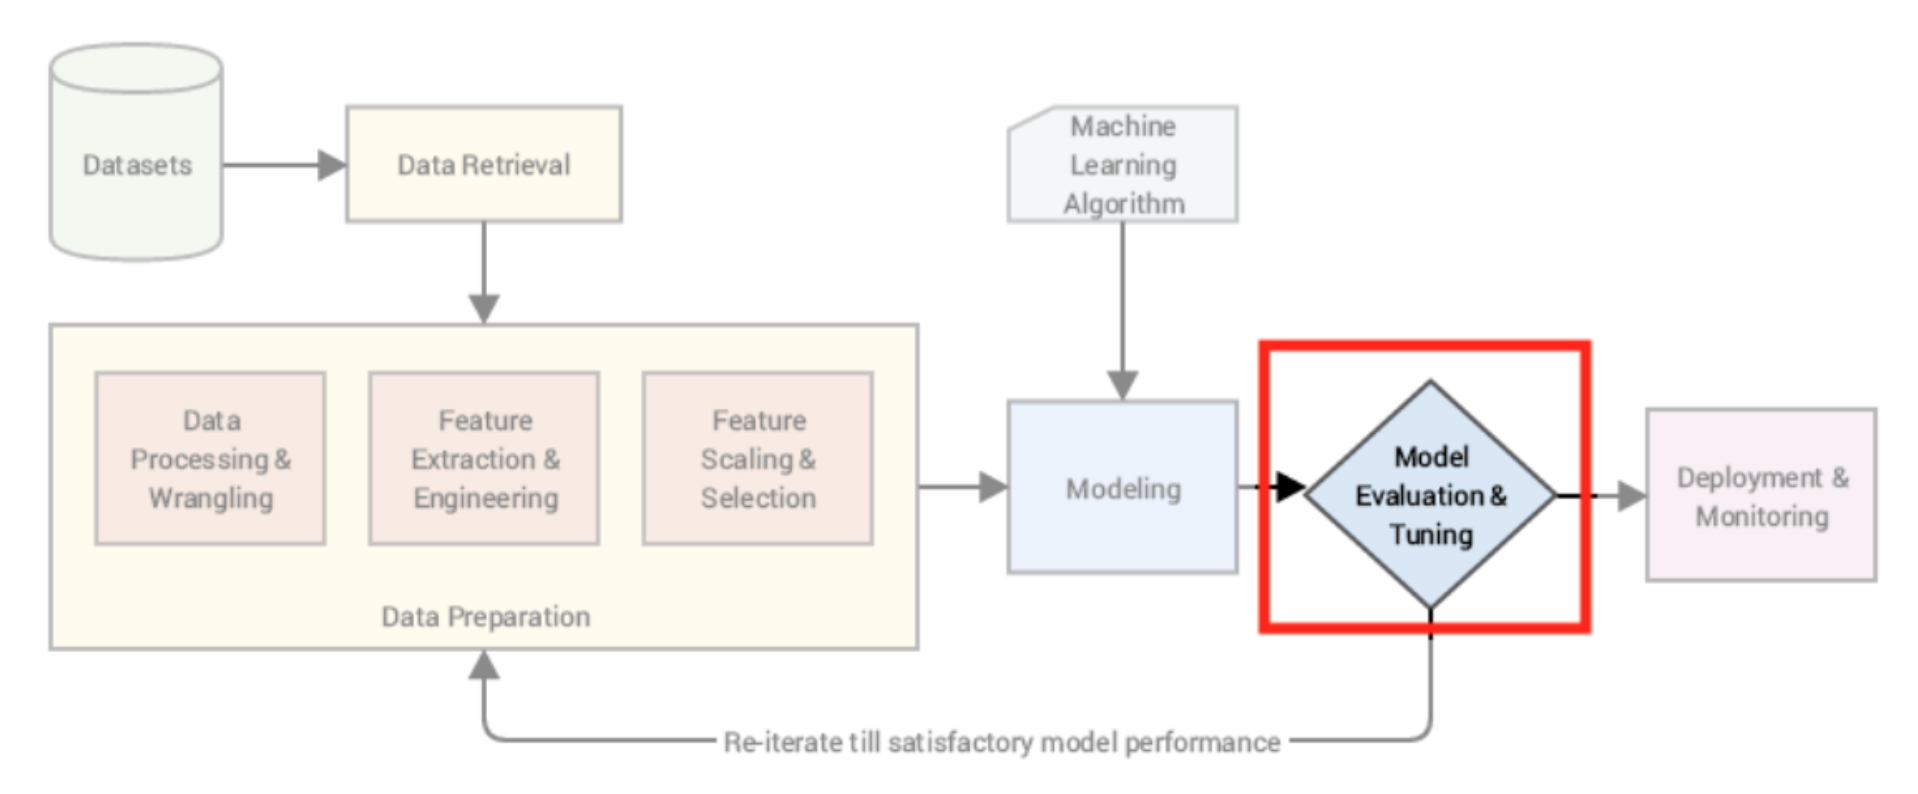

# Comment choisir les valeurs optimales pour les hyperparamètres ?

On a vu comment optimiser par exemple la valeur de `n_neighbors`. En bouclant, puis testant différentes valeurs de l'hyperparamètre.
Comment faire lorsque l'on a beaucoup plus d'hyperparamètres ?  

`SkLearn` met à dispositions des outils:
* `GridSearchCV`
* `RandomizedSearchCV`

## La méthode `GridSearchCV`

Cette méthode explore toutes les différentes combinaisons de valeurs d'hyperparamètres pour trouver celles qui optimisent les performances.  
Il faut alors spécifier les valeurs à tester dans une grille.

Imaginons qu'on cherche à optimiser les valeurs des hyperparamètres `n_neighbors` et `weights` qui sont des hyperparamètres de l'algorithme `KNeighborsClassifier`

In [1]:
grid = {"n_neighbors": [2, 5, 10],
        "weights": ["distance", "uniform"]
}

💻 Voyons un exemple avec l'algorithme `DecisionTreeClassifier`, et le jeu de données `titanic`.

In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

url = 'https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv'
df_titanic = pd.read_csv(url)
df_titanic.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


L'objectif est de prédire si une personne à survécu [1] ou non [0]

In [3]:
len(df_titanic)

887

Un peu de feature engineering...

In [4]:
df_titanic.isnull().sum()

Survived                   0
Pclass                     0
Name                       0
Sex                        0
Age                        0
Siblings/Spouses Aboard    0
Parents/Children Aboard    0
Fare                       0
dtype: int64

In [5]:
df_titanic["Family"] = df_titanic["Siblings/Spouses Aboard"] + df_titanic["Parents/Children Aboard"]

df_titanic

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Family
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500,1
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833,1
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250,0
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000,1
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500,0
...,...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000,0
883,1,1,Miss. Margaret Edith Graham,female,19.0,0,0,30.0000,0
884,0,3,Miss. Catherine Helen Johnston,female,7.0,1,2,23.4500,3
885,1,1,Mr. Karl Howell Behr,male,26.0,0,0,30.0000,0


# Preprocessing

On va `OneHotEncoding` (comme pd.get_dummies()) la colonne `PClass`.

In [6]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse = False)

ohe.fit(df_titanic[["Pclass"]])

df_titanic[ohe.get_feature_names(["Pclass"])] = ohe.transform(df_titanic[["Pclass"]])

df_titanic

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Family,Pclass_1,Pclass_2,Pclass_3
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500,1,0.0,0.0,1.0
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833,1,1.0,0.0,0.0
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250,0,0.0,0.0,1.0
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000,1,1.0,0.0,0.0
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000,0,0.0,1.0,0.0
883,1,1,Miss. Margaret Edith Graham,female,19.0,0,0,30.0000,0,1.0,0.0,0.0
884,0,3,Miss. Catherine Helen Johnston,female,7.0,1,2,23.4500,3,0.0,0.0,1.0
885,1,1,Mr. Karl Howell Behr,male,26.0,0,0,30.0000,0,1.0,0.0,0.0


On va encoder la colonne `Sex`

In [7]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()

lb.fit(df_titanic[["Sex"]])

df_titanic["Sex"] = lb.transform(df_titanic[["Sex"]])

df_titanic.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Family,Pclass_1,Pclass_2,Pclass_3
0,0,3,Mr. Owen Harris Braund,1,22.0,1,0,7.2500,1,0.0,0.0,1.0
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,0,38.0,1,0,71.2833,1,1.0,0.0,0.0
2,1,3,Miss. Laina Heikkinen,0,26.0,0,0,7.9250,0,0.0,0.0,1.0
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,0,35.0,1,0,53.1000,1,1.0,0.0,0.0
4,0,3,Mr. William Henry Allen,1,35.0,0,0,8.0500,0,0.0,0.0,1.0


On évacue les colonnes qui ne serviront pas pour entraîner le modèle:

In [8]:
y = df_titanic["Survived"]

df_titanic.drop(columns = ["Survived", "Pclass", "Name"], inplace = True)

In [9]:
df_titanic

,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Family,Pclass_1,Pclass_2,Pclass_3
0,1,22.0,1,0,7.2500,1,0.0,0.0,1.0
1,0,38.0,1,0,71.2833,1,1.0,0.0,0.0
2,0,26.0,0,0,7.9250,0,0.0,0.0,1.0
3,0,35.0,1,0,53.1000,1,1.0,0.0,0.0
4,1,35.0,0,0,8.0500,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
882,1,27.0,0,0,13.0000,0,0.0,1.0,0.0
883,0,19.0,0,0,30.0000,0,1.0,0.0,0.0
884,0,7.0,1,2,23.4500,3,0.0,0.0,1.0
885,1,26.0,0,0,30.0000,0,1.0,0.0,0.0


# On fait une mise à l'échelle de nos données

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_titanic[["Age", "Fare", "Family"]] = scaler.fit_transform(df_titanic[["Age", "Fare", "Family"]])

df_titanic

,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Family,Pclass_1,Pclass_2,Pclass_3
0,1,-0.529366,1,0,-0.503586,0.056543,0.0,0.0,1.0
1,0,0.604265,1,0,0.783412,0.056543,1.0,0.0,0.0
2,0,-0.245958,0,0,-0.490020,-0.562638,0.0,0.0,1.0
3,0,0.391709,1,0,0.417948,0.056543,1.0,0.0,0.0
4,1,0.391709,0,0,-0.487507,-0.562638,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
882,1,-0.175106,0,0,-0.388018,-0.562638,0.0,1.0,0.0
883,0,-0.741922,0,0,-0.046336,-0.562638,1.0,0.0,0.0
884,0,-1.592145,1,2,-0.177984,1.294904,0.0,0.0,1.0
885,1,-0.245958,0,0,-0.046336,-0.562638,1.0,0.0,0.0


In [11]:
y

0      0
1      1
2      1
3      1
4      0
      ..
882    0
883    1
884    0
885    1
886    0
Name: Survived, Length: 887, dtype: int64

In [12]:
X = df_titanic

## `train_test_split`

On sépare notre jeu de données en deux, amont d'une `GridSearchCV`

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

## `GridSearchCV` avec l'outil d'`SkLearn`

Voici ce qu'il faut faire en amont d'une `GridSearchCV`:

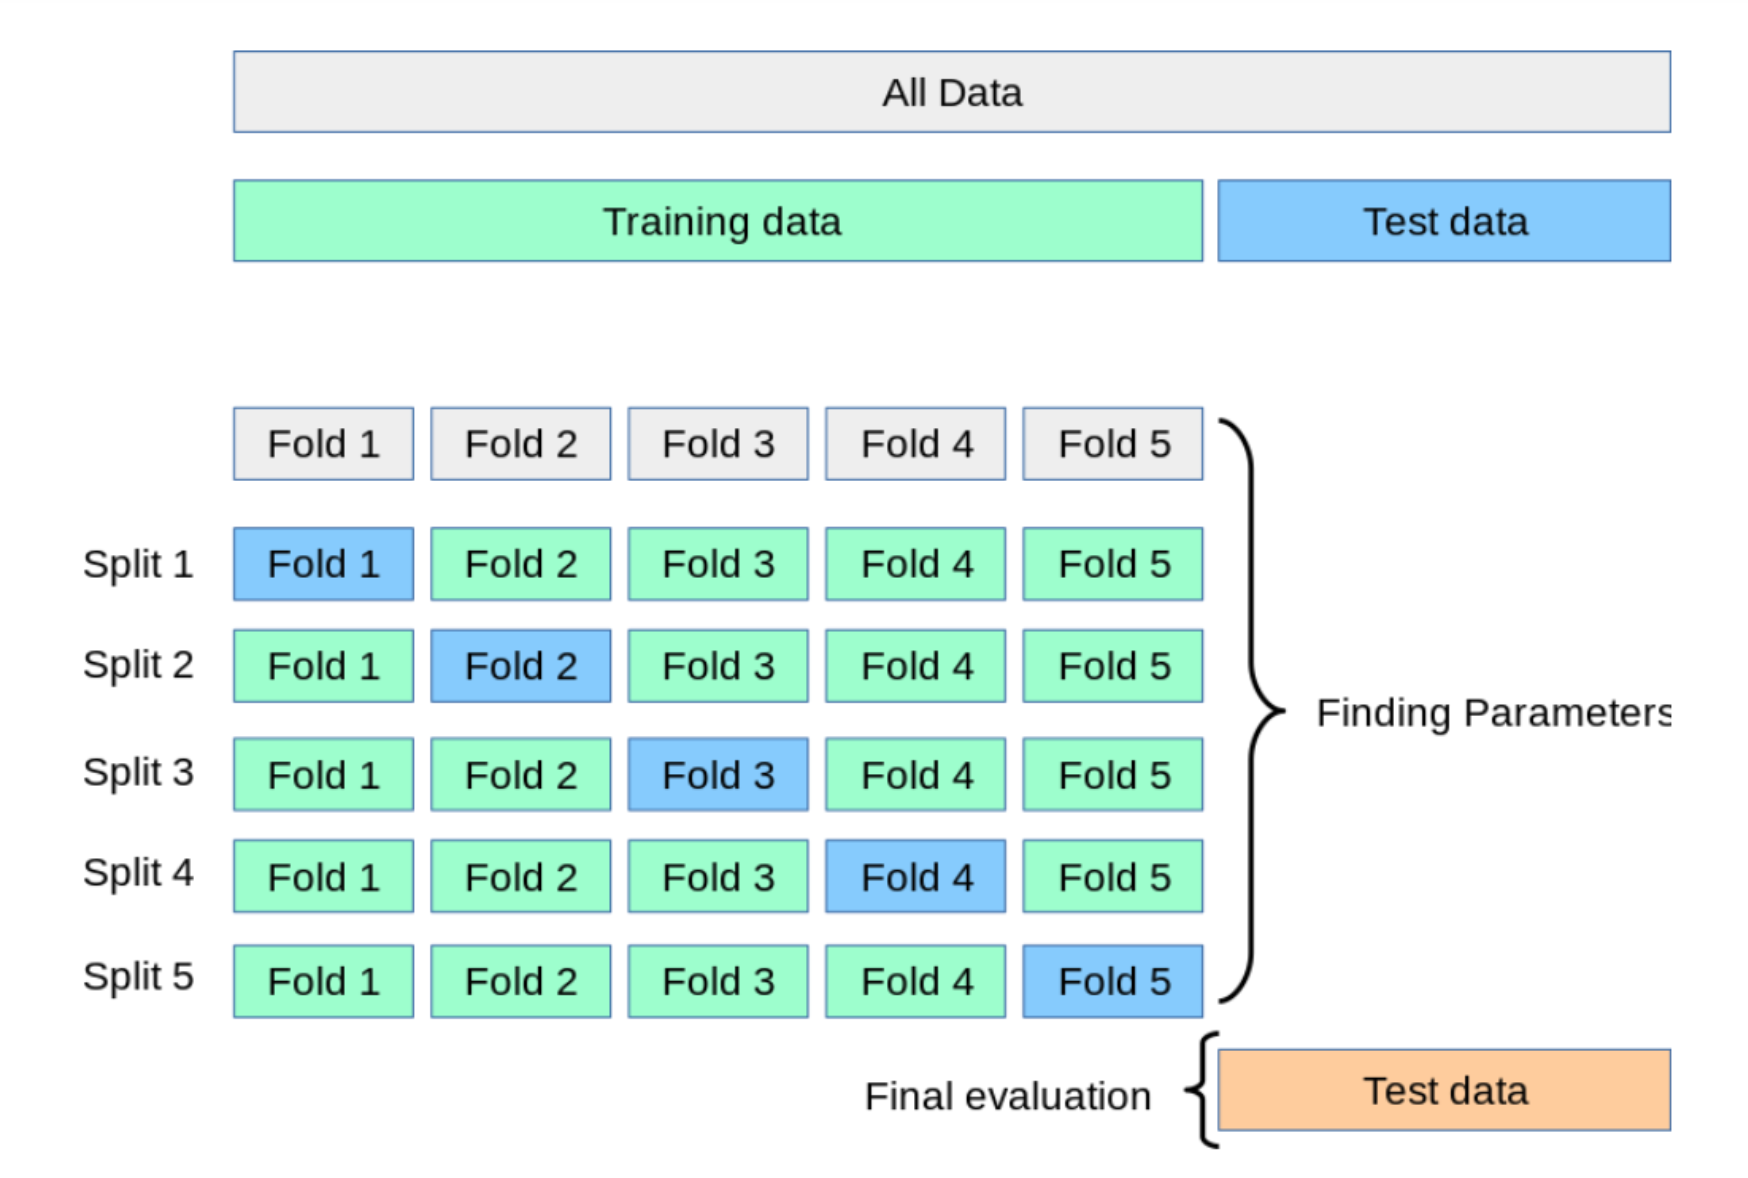

1. On sépare notre jeu de données avec `train_test_split`
2. On fait une `GridSearchCV` sur le jeu d'entraînement. `GridSearchCV` intègre la `cross validation`.
Pour rappel, pendant la cross validation, le jeu de donnée est séparé en plusieurs parties, et chacune des parties est une fois le jeu de test. On pourrait dire qu'on a quelquechose comme suit: `X_train_train` et `X_train_test`
3. Une fois que la meilleure combinaison de valeurs d'hyperparamètres est trouvée par la `GridSearchCV`, on créer un modèle avec les bonnes valeurs d'hyperparamètres, puis on évalue les performances de notre modèle sur notre jeu de test mis de côté avant d'effectuer une `GridSearchCV`.

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

grid = {"max_depth": [2, 3, 5],
        "min_samples_split": [2, 5, 10]}

search = GridSearchCV(model, grid, 
                      cv = 5,
                      n_jobs = -1,
                      return_train_score = True
                      )


search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True)

In [32]:
search.cv_results_

{'mean_fit_time': array([0.0052433 , 0.00770655, 0.00625529, 0.0072926 , 0.00580826,
        0.00672498, 0.00600977, 0.00522399, 0.00557532]),
 'mean_score_time': array([0.00324864, 0.00333304, 0.00412683, 0.00559292, 0.00349207,
        0.00355577, 0.00320048, 0.00345993, 0.00310006]),
 'mean_test_score': array([0.77720507, 0.77720507, 0.77720507, 0.81675157, 0.81533313,
        0.81675157, 0.80969933, 0.81251623, 0.81251623]),
 'mean_train_score': array([0.80501031, 0.80501031, 0.80501031, 0.83251671, 0.83251671,
        0.83251671, 0.85649576, 0.85332302, 0.85191209]),
 'param_max_depth': masked_array(data=[2, 2, 2, 3, 3, 3, 5, 5, 5],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[2, 5, 10, 2, 5, 10, 2, 5, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_val

In [16]:
search.cv_results_["mean_test_score"]

array([0.77720507, 0.77720507, 0.77720507, 0.81675157, 0.81675157,
       0.81533313, 0.81392468, 0.81251623, 0.81251623])

In [17]:
search.best_score_

0.8167515732694037

In [18]:
search.best_estimator_

DecisionTreeClassifier(max_depth=3)

In [19]:
search.best_params_

{'max_depth': 3, 'min_samples_split': 2}

In [20]:
best_model = search.best_estimator_

In [21]:
best_model.score(X_test, y_test)

0.8370786516853933

## Différentes métriques avec `GridSearchCV`

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

grid = {"max_depth": [2, 3, 5],
        "min_samples_split": [2, 5, 10]}

search = GridSearchCV(model, grid, 
                      scoring = ["accuracy", "f1"],
                      refit = "accuracy",
                      cv = 5,
                      n_jobs = -1
                      )


search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5],
                         'min_samples_split': [2, 5, 10]},
             refit='accuracy', scoring=['accuracy', 'f1'])

In [24]:
search.cv_results_

{'mean_fit_time': array([0.00599623, 0.00622149, 0.00493889, 0.00654535, 0.00663004,
        0.00505943, 0.00527978, 0.00516028, 0.00534697]),
 'mean_score_time': array([0.00515971, 0.0068913 , 0.00495367, 0.00572519, 0.00688581,
        0.00512085, 0.00493731, 0.00486388, 0.00459538]),
 'mean_test_accuracy': array([0.77720507, 0.77720507, 0.77720507, 0.81675157, 0.81675157,
        0.81533313, 0.81392468, 0.81393467, 0.81251623]),
 'mean_test_f1': array([0.685318  , 0.685318  , 0.685318  , 0.73836299, 0.73836299,
        0.73671998, 0.74068652, 0.73950085, 0.73780388]),
 'param_max_depth': masked_array(data=[2, 2, 2, 3, 3, 3, 5, 5, 5],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[2, 5, 10, 2, 5, 10, 2, 5, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_valu

In [25]:
search.cv_results_["mean_test_f1"]

array([0.685318  , 0.685318  , 0.685318  , 0.73836299, 0.73836299,
       0.73671998, 0.74068652, 0.73950085, 0.73780388])

## La liste des métriques que je peux passer à `GridSearchCV`

In [26]:
from sklearn.metrics import SCORERS

In [27]:
SCORERS

{'accuracy': make_scorer(accuracy_score),
 'adjusted_mutual_info_score': make_scorer(adjusted_mutual_info_score),
 'adjusted_rand_score': make_scorer(adjusted_rand_score),
 'average_precision': make_scorer(average_precision_score, needs_threshold=True),
 'balanced_accuracy': make_scorer(balanced_accuracy_score),
 'completeness_score': make_scorer(completeness_score),
 'explained_variance': make_scorer(explained_variance_score),
 'f1': make_scorer(f1_score, average=binary),
 'f1_macro': make_scorer(f1_score, pos_label=None, average=macro),
 'f1_micro': make_scorer(f1_score, pos_label=None, average=micro),
 'f1_samples': make_scorer(f1_score, pos_label=None, average=samples),
 'f1_weighted': make_scorer(f1_score, pos_label=None, average=weighted),
 'fowlkes_mallows_score': make_scorer(fowlkes_mallows_score),
 'homogeneity_score': make_scorer(homogeneity_score),
 'jaccard': make_scorer(jaccard_score, average=binary),
 'jaccard_macro': make_scorer(jaccard_score, pos_label=None, average=mac

## Les limites de `GridSearchCV`

* Coûteux en termes de calcul.
* La valeur optimale de l'hyperparamètre peut être manquée.

# `RandomizedSearchCV`

Il existe un outil alternatif à `GridSearchCV`, qui permet de tester beaucoup plus de combinaisons, sans avoir à rentrer manuellement toutes les valeurs que l'on souhaite tester.

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform, randint, norm

model = DecisionTreeClassifier(max_depth= 5)

grid = {"min_samples_split": randint(2, 40),
        "min_weight_fraction_leaf": loguniform(0.001, 0.5)}

# n_iter = 100, donc 100 combinaisons différentes seront testées.

r_search = RandomizedSearchCV(model, grid,
                              n_iter = 100,
                              cv = 5,
                              n_jobs = -1)

r_search.fit(X_train, y_train)

best_model = r_search.best_estimator_
best_model

DecisionTreeClassifier(max_depth=25, min_samples_split=22,
                       min_weight_fraction_leaf=0.004034955796027338)

In [30]:
best_model.score(X_test, y_test)

0.8033707865168539

Tout comme avec `GridSearchCV`, il est possible d'ajouter d'autres métriques.

# Stats module Example

## `norm()`

(array([1.2000e+01, 2.3800e+02, 2.4380e+03, 1.2470e+04, 2.9398e+04,
        3.2923e+04, 1.7538e+04, 4.4240e+03, 5.2900e+02, 3.0000e+01]),
 array([ 0.76188659,  2.55204576,  4.34220493,  6.13236409,  7.92252326,
         9.71268243, 11.50284159, 13.29300076, 15.08315993, 16.87331909,
        18.66347826]),
 <a list of 10 Patch objects>)

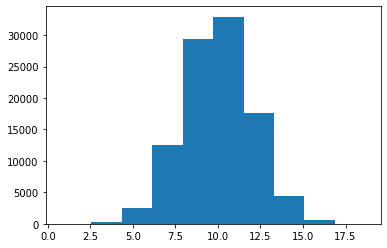

In [34]:
import matplotlib.pyplot as plt
from scipy import stats

dist = stats.norm(10,2)

r = dist.rvs(size = 100_000)
plt.hist(r)

## `randint()`

(array([1028., 1052., 1015.,  999.,  969., 1032.,  991.,  984.,  962.,
         968.]),
 array([ 1. , 10.8, 20.6, 30.4, 40.2, 50. , 59.8, 69.6, 79.4, 89.2, 99. ]),
 <a list of 10 Patch objects>)

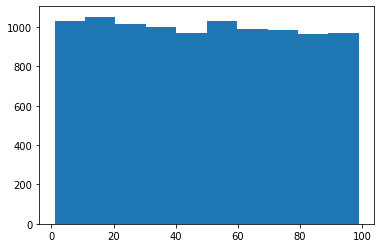

In [37]:
dist = stats.randint(1,100)

r = dist.rvs(size = 10_000)
plt.hist(r)

## `uniform()`

(array([10063., 10269., 10074., 10085.,  9869.,  9961.,  9862.,  9909.,
        10077.,  9831.]),
 array([  1.00019141,  11.00009968,  21.00000795,  30.99991621,
         40.99982448,  50.99973275,  60.99964102,  70.99954929,
         80.99945755,  90.99936582, 100.99927409]),
 <a list of 10 Patch objects>)

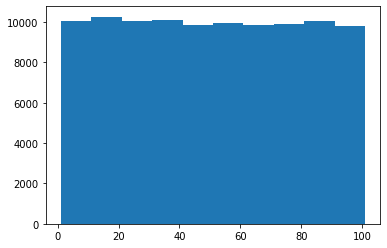

In [39]:
dist = stats.uniform(1, 100)

r = dist.rvs(size = 100_000)
plt.hist(r)

## `loguniform()`

(array([66907.,  9853.,  5802.,  4251.,  3176.,  2508.,  2233.,  1937.,
         1739.,  1594.]),
 array([0.001     , 0.10088821, 0.20077641, 0.30066461, 0.40055281,
        0.50044101, 0.60032922, 0.70021742, 0.80010562, 0.89999382,
        0.99988202]),
 <a list of 10 Patch objects>)

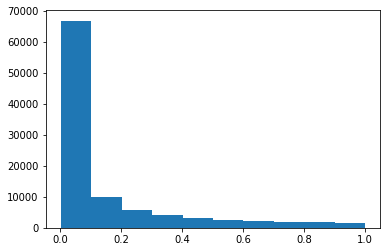

In [35]:
dist = stats.loguniform(0.001,1)

r = dist.rvs(size= 100_000)
plt.hist(r)

## Les limites de `RandomizedSearchCV`

* Encore plus couteux en calcul
* Ce sont des valeurs différentes qui sont testés à chaque fois. En effet, il est impossible de "freezer" une des valeurs si on le souhaite.